# Task description #



Let's imagine that you are a Data Scientist responsible for data exploration to find valuable business insights for CX department. 
You were provided with a dataset, generated from interviews with random people across Poland. The aim of the interviews was to measure Aided Brand Awareness and NPS. The questions are:

- what can we learn from the data? 
- what can we do to understand customers better?



* QuestID	- index

* InterviewDate - date of interview

* InterviewLengthSec - how long was interview?

* InterviewStatus	- completed [value = 1] or not [value = 0]

* AgeBands - age buckets; codified

* Region - region of Poland; codified

* Columns: BA02Rxxx - answers for questions 'have you heard of company BA02Rxxx (company names codified)

* SU01R - codified company names, who deliver product for Customers

* NPS01R - value of NPS question (Net promoter score (NPS))

# Data preparation #

## Loading data ##

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import collections
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(style="white", palette="pastel")

In [2]:
df = pd.read_csv("Results_RAW.csv", sep=';')
df.head()

,QuestID,InterviewDate,InterviewLengthSec,InterviewStatus,AgeBands,Region,BA02R_271_PL,BA02R_272_PL,BA02R_273_PL,BA02R_274_PL,BA02R_279_PL,BA02R_280_PL,BA02R_282_PL,BA02R_283_PL,BA02R_284_PL,BA02R_285_PL,SU01R,NPS01R
0,1,12.04.2020,107,1,3,911,0,1,1,1,0,1,1,1,0,0,552,0
1,2,07.04.2020,379,1,5,903,1,1,1,1,0,0,1,1,0,0,543,5
2,3,12.04.2020,384,1,3,901,0,1,0,0,0,0,0,0,0,0,542,2
3,4,03.04.2020,227,1,5,914,0,0,0,0,0,0,1,0,0,0,552,6
4,5,21.04.2020,176,1,2,907,1,1,1,1,0,1,1,1,0,0,541,0


## Looking for missing values and outliers ##

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3546 entries, 0 to 3545
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   QuestID             3546 non-null   int64 
 1   InterviewDate       3546 non-null   object
 2   InterviewLengthSec  3546 non-null   int64 
 3   InterviewStatus     3546 non-null   int64 
 4   AgeBands            3546 non-null   int64 
 5   Region              3546 non-null   int64 
 6   BA02R_271_PL        3546 non-null   int64 
 7   BA02R_272_PL        3546 non-null   int64 
 8   BA02R_273_PL        3546 non-null   int64 
 9   BA02R_274_PL        3546 non-null   int64 
 10  BA02R_279_PL        3546 non-null   int64 
 11  BA02R_280_PL        3546 non-null   int64 
 12  BA02R_282_PL        3546 non-null   int64 
 13  BA02R_283_PL        3546 non-null   int64 
 14  BA02R_284_PL        3546 non-null   int64 
 15  BA02R_285_PL        3546 non-null   int64 
 16  SU01R               3546

In [4]:
df.describe()

,QuestID,InterviewLengthSec,InterviewStatus,AgeBands,Region,BA02R_271_PL,BA02R_272_PL,BA02R_273_PL,BA02R_274_PL,BA02R_279_PL,BA02R_280_PL,BA02R_282_PL,BA02R_283_PL,BA02R_284_PL,BA02R_285_PL,SU01R,NPS01R
count,3546.000000,3546.000000,3546.0,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000,3546.000000
mean,1773.500000,676.706148,1.0,3.434292,908.022843,0.430626,0.864636,0.819797,0.801466,0.312747,0.433446,0.837563,0.780880,0.124929,0.131134,543.713480,4.429216
std,1023.786355,5516.797349,0.0,1.379601,4.048965,0.495234,0.342160,0.384411,0.398952,0.463678,0.495621,0.368903,0.413709,0.330686,0.337594,8.501272,2.888659
min,1.000000,44.000000,1.0,1.000000,901.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,421.000000,0.000000
25%,887.250000,239.000000,1.0,2.000000,906.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,541.000000,2.000000
50%,1773.500000,341.000000,1.0,3.000000,907.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,542.000000,4.000000
75%,2659.750000,501.000000,1.0,5.000000,912.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,544.000000,7.000000
max,3546.000000,237215.000000,1.0,5.000000,916.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,555.000000,9.000000


I assume interviews that took longer than 30 minutes are invalid and should be removed from the data. 3477 observations were left.

In [5]:
t_max = 30 * 60
df = df[df.InterviewLengthSec < t_max]

## Cleaning data ##

In [6]:
# providing more readable column names

df.columns = df.columns.str.replace('BA02R', 'BrandAwareness')
df.columns = df.columns.str.replace('_PL', '')
df.rename(columns={"SU01R": "Provider", "NPS01R": "NPS"}, inplace=True)
df['AgeBands'] = df['AgeBands'].astype('category')
df['Region'] = df['Region'].astype('string')
df['Provider'] = df['Provider'].astype('string')

There may be a question if unfinished interviews should be taken into account. However, there is no such interview in the data. This feture may be removed.

In [7]:
df['InterviewStatus'].value_counts()
df.drop('InterviewStatus', axis=1, inplace=True)

## Adding aggregation features ##

The features corresponding to the NPS label and the number of brands that the customer knows will be added.

* additional feature corresponding to NPS score: The NPS assumes a subdivision of respondents into "promoters" who provide ratings of 9 or 10, "passives" who provide ratings of 7 or 8, and "detractors" who provide ratings of 6 or lower (source: Wikipedia). However, the distribution of the score values shows that no respondents gave a score equal to 10, but there is also an NPS equal to 0. That is why I decided to shift these boundaries and assign the label 'promoter' to anyone who answered above or equal to 8, and 'passive' to anyone who answered above or equal to 5.

* The 'KnownBrandsNumber' feature indicates the number of brands that a customer is aware of.

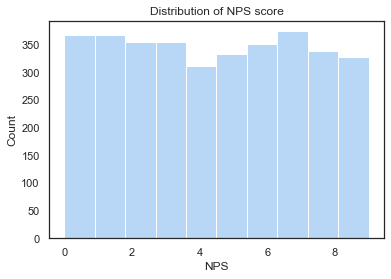

In [8]:
sns.histplot(x="NPS", data=df, bins=10)
plt.title("Distribution of NPS score", fontsize='large')
plt.show()

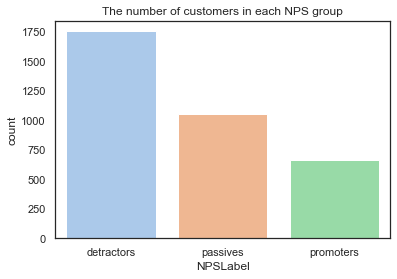

In [9]:
def get_nps_label(nps_score):
    if nps_score >= 8:
        return "promoters"
    elif nps_score >= 5:
        return "passives"
    else:
        return "detractors"


df['NPSLabel'] = df['NPS'].apply(lambda x: get_nps_label(x))

sns.countplot(x="NPSLabel", data=df)
plt.title("The number of customers in each NPS group", fontsize='large')
plt.show()

Add a feature corresponding to sum of how many brands was respondent aware of:

In [10]:
filter_col = [col for col in df.columns if col.startswith('BrandAwareness')]
df['KnownBrandsNumber'] = df[filter_col].sum(axis=1)

# Things we can learn from the data #

## Which suppliers have the most satisfied customers? ##

***Market leaders among providers based on questionnaire***

Based on the research:

* Provider **541** is a market leader supplying more than 25% of respondents with the product
* Market followers are providers **542, 543, 552, 544** each with more than 10% of market shares

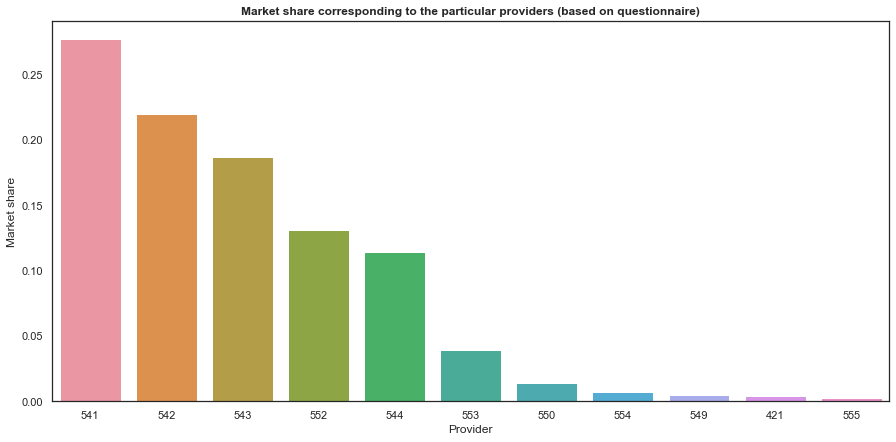

In [11]:
plt.rcParams['figure.figsize'] = [15, 7]

providers_market_share = df.groupby('Provider').count()['QuestID'] / len(df)
providers_market_share.sort_values(ascending=False, inplace=True)
sns.barplot(x=providers_market_share.index, y=providers_market_share)
plt.title(
    "Market share corresponding to the particular providers (based on questionnaire)",
    weight='bold',
    fontsize='large')
plt.ylabel("Market share")
plt.show()

In [12]:
print("The number of respondents corresponding to the particular providers: ")
df['Provider'].value_counts()

The number of respondents corresponding to the particular providers: 


541    963
542    763
543    649
552    456
544    396
553    136
550     49
554     26
549     17
421     13
555      9
Name: Provider, dtype: Int64

***Providers who customers are most and least happy with***

* Provider **555** has the ***highest proportion of customers who are unhappy***. Almost 60 % of customers would not be eager to recommend this provider and gave the NPS score lower than 5. However, this is a very small player on the market with a share of less than 1%

* Provider with the ***highest share of promoters among respondents*** is provider **421** with the percentage of happy customers a little below 40%. This is again a very small player on the market with a similar share as 555.

However, as they are providers for only a few respondents, the scores may not be representative.

More important are the scores for big players on the market who were providers for many respondents:

* Customers are dissatisfied with the following providers, both of which are major players: **552** and **543**. They are the **third and fourth most common providers**, and they are also in the top five companies **with the biggest share of detractors**.

* The **big player** that is among the list of top companies **with the biggest share of promoters** is **542**. 

* Provider **553** is particularly intriguing. It is a provider for **139 respondents** and ranks fourth in both the share of detractors and the share of promoters, indicating that this provider elicits either positive or negative feelings in customers, rarely neutral.

* Even though the results may not be statistically significant due to the small number of respondents, there are a lot of small companies(421, 550, 549) that have a bigger share of promoters than market leaders according to the questionaire. Maybe they should be analysed and some of their practices should be taken into consideration by the biggest players.

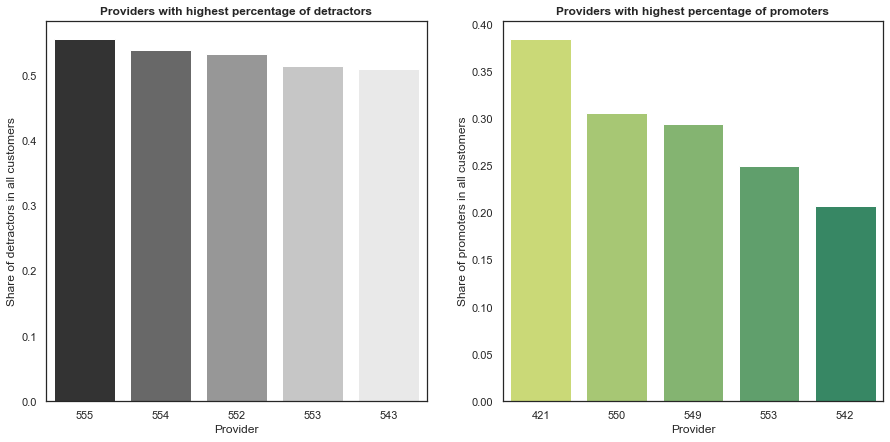

In [13]:
# counting customers by Provider and NPSLabel
grouped_by_prov_npslab = df.groupby(['Provider',
                                     'NPSLabel']).count()['QuestID']

# counting customers by provider
grouped_by_prov = df.groupby(['Provider']).count()['QuestID']

# dividing so there will be shares instead of counts
grouped_by_prov_npslab_percent = grouped_by_prov_npslab / grouped_by_prov

# 5 providers with highest detractors share
detractors_shares = grouped_by_prov_npslab_percent.loc[:, 'detractors']
detractors_shares_sorted = detractors_shares.sort_values(
    ascending=False).head(5).reset_index()
detractors_shares_sorted.rename(
    columns={'QuestID': 'Share of detractors in all customers'}, inplace=True)

# 5 providers with highest promoters share
promoters_shares = grouped_by_prov_npslab_percent.loc[:, 'promoters']
promoters_shares_sorted = promoters_shares.sort_values(
    ascending=False).head(5).reset_index()
promoters_shares_sorted.rename(
    columns={'QuestID': 'Share of promoters in all customers'}, inplace=True)

# Plotting
plt.subplot(1, 2, 1)

sns.barplot(x=detractors_shares_sorted['Provider'],
            y=detractors_shares_sorted['Share of detractors in all customers'],
            palette='Greys_r')

plt.title("Providers with highest percentage of detractors",
          weight='bold',
          fontsize='large')

plt.subplot(1, 2, 2)
sns.barplot(x=promoters_shares_sorted['Provider'],
            y=promoters_shares_sorted['Share of promoters in all customers'],
            palette='summer_r')

plt.title("Providers with highest percentage of promoters",
          fontweight='bold',
          fontsize='large')
plt.show()

For 5 top market players among providers, the ratio between number of promoters and detractors was calculated, stating that again

* Provider **542** has the best reputation among biggest providers with the ratio of promoters divided by detractors at approximately **42%**
* Provider **544** has the worst reputation among biggest providers with the ratio of around **34%**

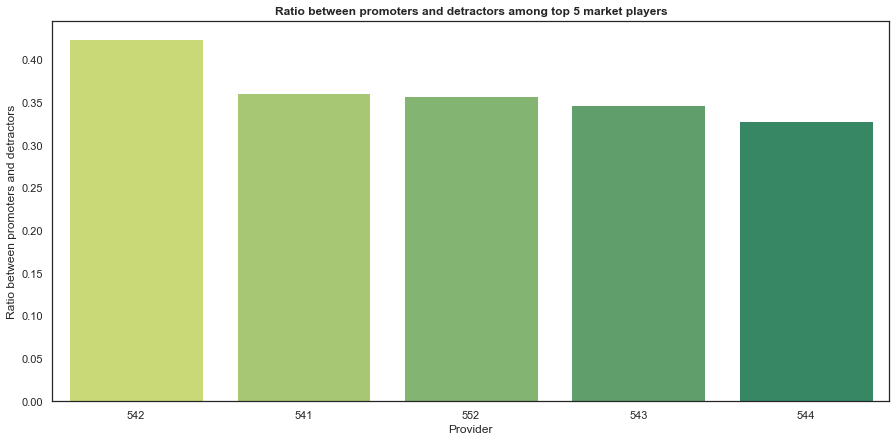

In [14]:
providers_top_5 = df['Provider'].value_counts().head(5).index.values

promoters_detractors_ratio = promoters_shares / detractors_shares
promoters_detractors_ratio = promoters_detractors_ratio.sort_values(
    ascending=False).reset_index()
promoters_detractors_ratio.rename(
    columns={'QuestID': 'Ratio between promoters and detractors'},
    inplace=True)

ax = sns.barplot(
    x='Provider',
    y='Ratio between promoters and detractors',
    data=promoters_detractors_ratio[
        promoters_detractors_ratio['Provider'].isin(providers_top_5)],
    palette='summer_r')

plt.title("Ratio between promoters and detractors among top 5 market players",
          fontweight='bold',
          fontsize='large')
plt.show()

## What brands are customers most aware of? ##

* The brands that **more than 80% of respondents are familiar with** are **272, 282, 273, 274, 283**. They are probably the **giants** that sell their products in almost all regions of Poland. 

* The other three brands, that I will call **middle brands**, **280, 271, 279** are **known by 30%-40% of customers**, meaning they are way behind the leaders but still have some market position. **Brands 284 and 285 are known by less than 20% of respondents**. It is possible that they are selling their product in only one or two regions. I will call them the **minor** brands.

* Most lesser-known brands have similar awareness across all regions, with only minor variations. In most regions, the most known brands **272, 282, 273, 274, 283** occupy the first three places when it comes to brand awareness. **Region 907** and **Brand 271** are the **exceptions**. Despite being a medium provider (general awareness of 30%-40%), it is one of the most well-known brands in Region 907.

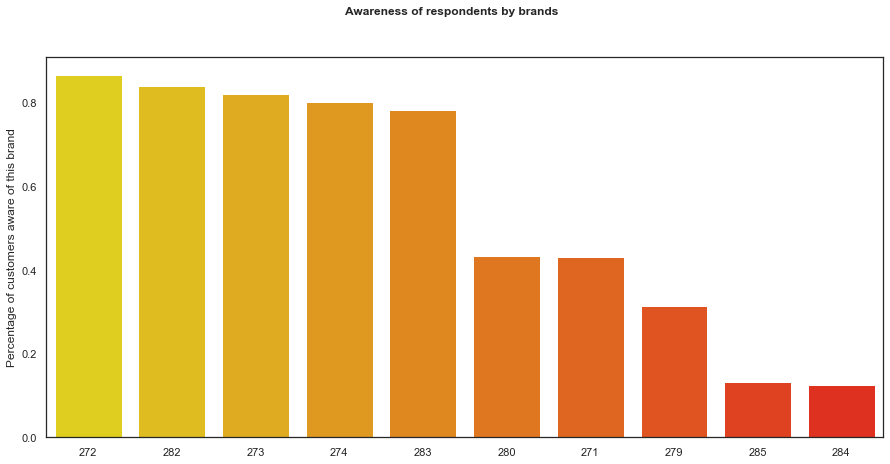

In [15]:
brand_codes = [
    '271', '272', '273', '274', '279', '280', '282', '283', '284', '285'
]

awareness_by_brand = {}

for brand_code in brand_codes:
    brand = 'BrandAwareness_' + brand_code
    mean = np.mean(df[brand])
    awareness_by_brand[brand_code] = mean

awareness_by_brand_sorted = dict(
    sorted(awareness_by_brand.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(awareness_by_brand_sorted.keys()),
            y=[float(x) for x in awareness_by_brand_sorted.values()],
            palette='autumn_r')

plt.ylabel("Percentage of customers aware of this brand")
plt.suptitle("Awareness of respondents by brands",
             weight='bold',
             fontsize='large')
plt.show()

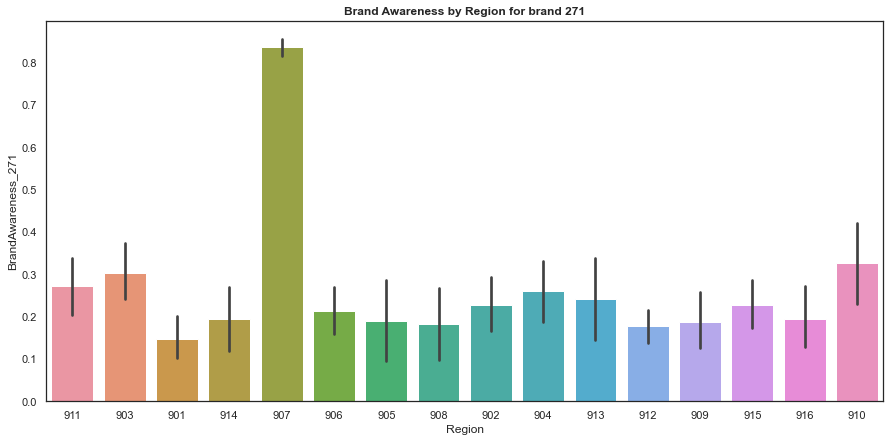

In [16]:
def make_barplot_brand_per_region(df, brand_code):
    sns.barplot(x="Region",
                y='BrandAwareness_' + brand_code,
                data=df,
                estimator=np.mean)
    plt.title("Brand Awareness by Region for brand " + brand_code,
              weight='bold',
              fontsize='large')


make_barplot_brand_per_region(df, '271')

## Are people in some age group familiar with more brands in general? ##

Respondents in **fifth age band were familiar on average with one brand less than respondents from the second and third age groups**. Also, the **first group** had a significantly lower average than the other groups, but was still higher than the fifth group. If the groups' numbers correspond to real order, these two groups probably mean the youngest and oldest respondents.

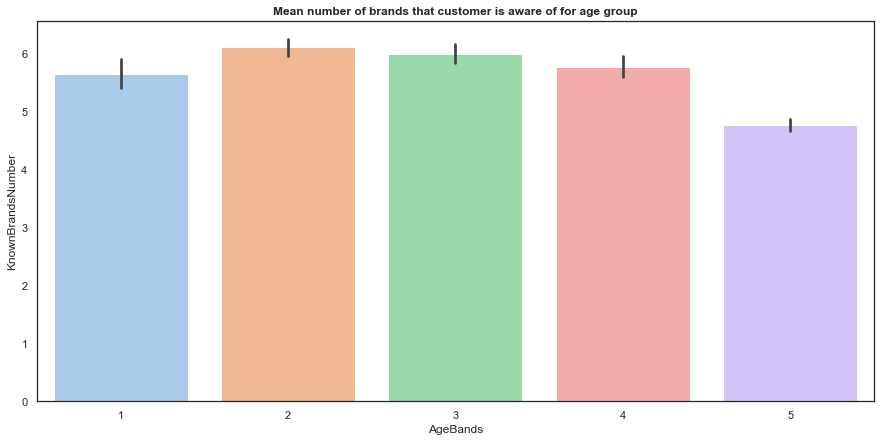

In [17]:
sns.barplot(x="AgeBands", y='KnownBrandsNumber', data=df, estimator=np.mean)

plt.title("Mean number of brands that customer is aware of for age group",
          weight='bold',
          fontsize='large')
plt.show()

## Are some brands better known in particular age groups? ##

As it was pointed out, the first and fifth age bands have a lower average when it comes to the number of brands they are aware of. When we look at particular brands, the difference is especially visible for brands:

- For some brands, the difference between age groups it exceptionally vivid. Brand 271, which is well known for people in groups 2, 3, and 4 (awareness 60%), is almost half as well known for people in age bands 1 and 5 (30%-20%). The situation is similar for brands 284 and 285.

- However, there are some brands that are best known for people in first age band. These are brands 279 and 280.

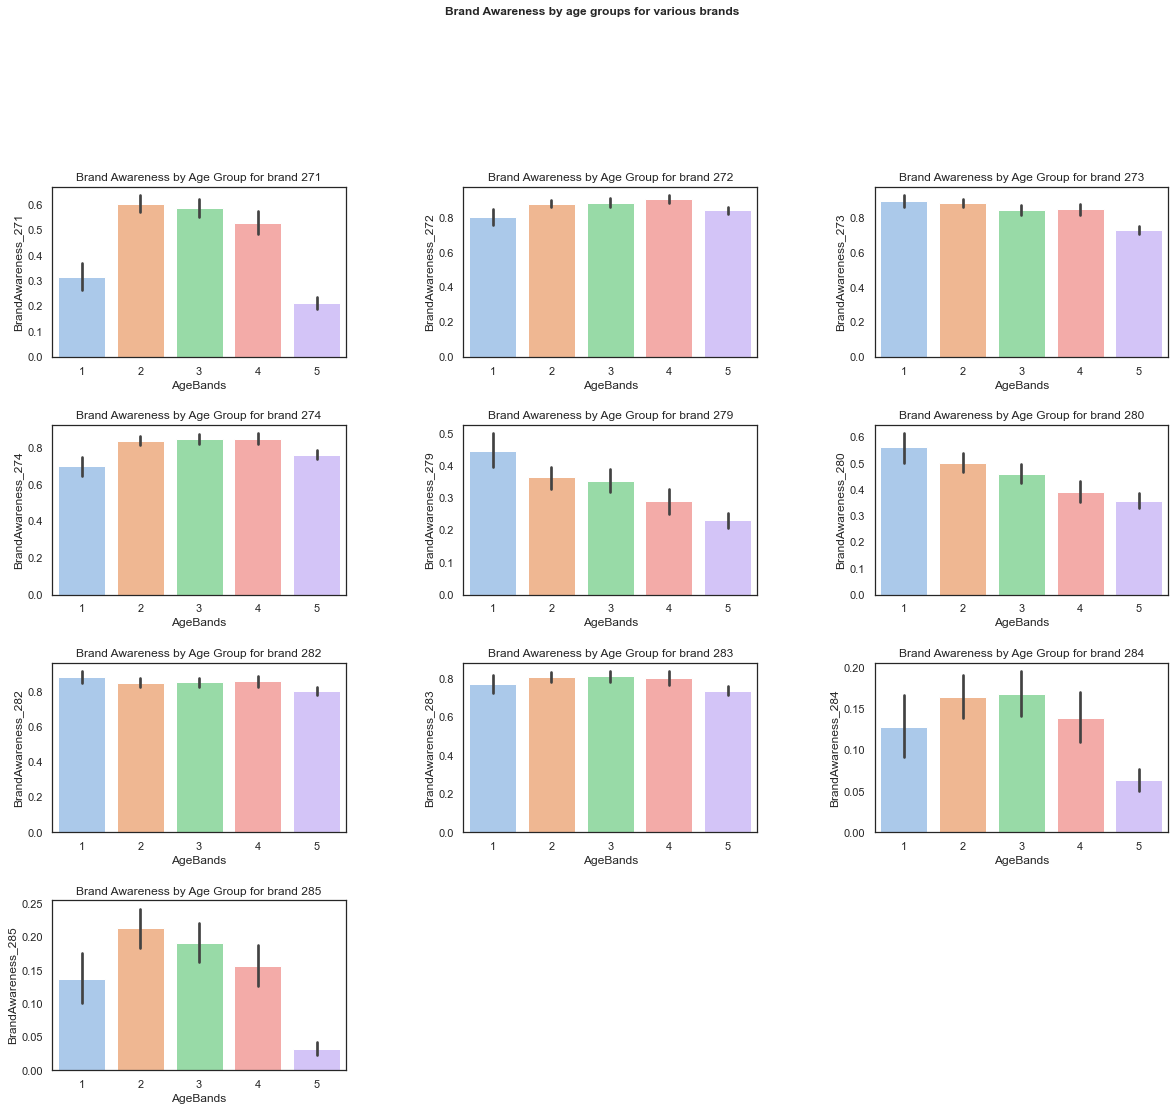

In [18]:
def make_barplot_brand_per_ageband(df, brand_code):
    sns.barplot(x="AgeBands",
                y='BrandAwareness_' + brand_code,
                data=df,
                estimator=np.mean)
    plt.title("Brand Awareness by Age Group for brand " + brand_code)


fig = plt.figure(figsize=(20, 25))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.suptitle("Brand Awareness by age groups for various brands",
             weight='bold',
             fontsize='large')

for brand_code, i in zip(brand_codes, range(1, len(brand_codes) + 1)):
    plt.subplot(6, 3, i)
    make_barplot_brand_per_ageband(df, brand_code)

## Is there relation between number of brands customer is aware of and NPS score ##


* There seems to be no visible relation between number of brands known and NPS
* The correlation between features are also minor

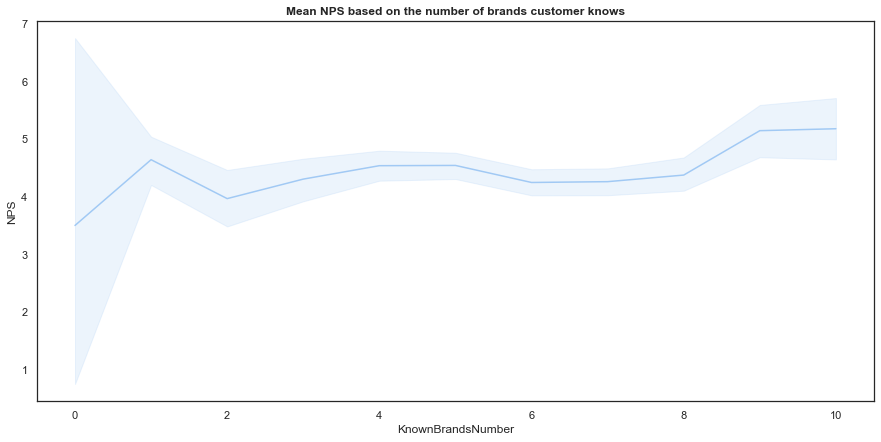

In [19]:
sns.lineplot(x="KnownBrandsNumber", y="NPS", data=df)
plt.title("Mean NPS based on the number of brands customer knows",
          weight='bold',
          fontsize='large')
plt.show()

In [20]:
corr = df[['KnownBrandsNumber', 'NPS']].corr()
print(corr)

                   KnownBrandsNumber       NPS
KnownBrandsNumber           1.000000  0.026799
NPS                         0.026799  1.000000


# What can we do to understand customers better #

## Factor analysis of Brand Awareness ##

We can group customers into the segments based on the interview answers. But first I will perform factor analysis for features of BrandAwareness because they probably have a lot of common variance. 

<AxesSubplot:>

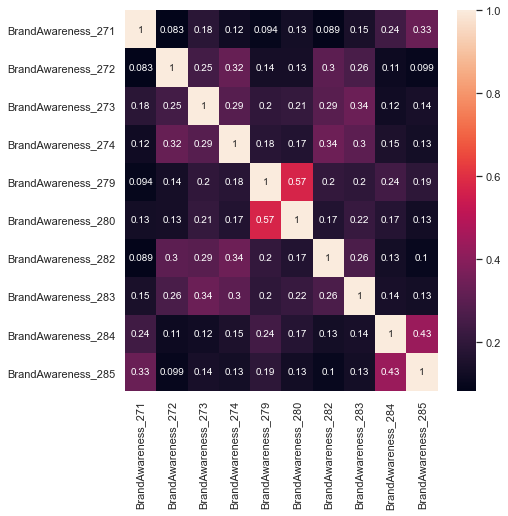

In [21]:
df_for_factor_analysis = df[[
    col for col in df.columns if col.startswith('BrandAwareness_')
]]
corr = df_for_factor_analysis.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corr, annot=corr)

In [22]:
kmo_all, kmo_score = calculate_kmo(df_for_factor_analysis)
print("Value of KMO statistic " + str(round(kmo_score, 2)))

Value of KMO statistic 0.75


In [23]:
fa = FactorAnalyzer()
fa.fit(df_for_factor_analysis)
eigenvalues, _ = fa.get_eigenvalues()
print("Number of factors: " + str(len([x for x in eigenvalues if x >= 1])))

Number of factors: 3


In [24]:
fa = FactorAnalyzer(n_factors=3, rotation="varimax")
fa.fit(df_for_factor_analysis)
print(
    pd.DataFrame(fa.get_factor_variance(),
                 index=['Variance', 'Proportional Var', 'Cumulative Var']))

                         0         1         2
Variance          1.482118  1.180228  1.152954
Proportional Var  0.148212  0.118023  0.115295
Cumulative Var    0.148212  0.266235  0.381530


In [25]:
print(pd.DataFrame(fa.loadings_, index=df_for_factor_analysis.columns))
#print(pd.DataFrame(fa.get_communalities(),index=df_for_factor_analysis.columns,columns=['Communalities']))

                           0         1         2
BrandAwareness_271  0.149066  0.042112  0.410251
BrandAwareness_272  0.511882  0.049127  0.068428
BrandAwareness_273  0.502146  0.132393  0.138715
BrandAwareness_274  0.571770  0.081055  0.110411
BrandAwareness_279  0.156233  0.830347  0.151672
BrandAwareness_280  0.195826  0.631771  0.108560
BrandAwareness_282  0.536515  0.115399  0.068750
BrandAwareness_283  0.500241  0.139166  0.122814
BrandAwareness_284  0.117064  0.163213  0.527450
BrandAwareness_285  0.065211  0.063330  0.784685


In [26]:
X_factors = fa.transform(df_for_factor_analysis)
df['FactorGiants'] = X_factors[:, 0]
df['FactorMiddle'] = X_factors[:, 1]
df['FactorMinor'] = X_factors[:, 2]

After Factor Analysis there are 3 factors:

* Factor 0 corresponding mostly to awareness of brand 272, 273, 274, 282, 283 (giants)
* Factor 1 corresponding to awareness of brand 279 and 280 (middle brands)
* Factor 2 corresponding to awareness of 271, 284, 285 (minor brands)

## Customers Segmentation ##

I have conducted customers segmentation based on their age band, number of known brands, NPS score, fact if he/she knows giants, middle and minor brands.

In [27]:
df_for_analysis = df[[
    'AgeBands', 'KnownBrandsNumber', 'NPS', 'FactorGiants', 'FactorMiddle',
    'FactorMinor'
]]
df_for_analysis['AgeBands'] = df_for_analysis['AgeBands'].astype('int')
df_for_analysis.head()

,AgeBands,KnownBrandsNumber,NPS,FactorGiants,FactorMiddle,FactorMinor
0,3,6,0,0.661104,-0.223887,-0.475409
1,5,6,5,0.668275,-0.761142,-0.154317
2,3,1,2,-1.943164,-0.468260,-0.401853
3,5,1,6,-1.941843,-0.424620,-0.414613
4,2,7,0,0.719049,-0.254638,-0.176756


In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(df_for_analysis)

sse = []
for n in range(1, 11):
    algorithm = KMeans(init='k-means++', n_clusters=n, tol=10e-8)
    algorithm.fit(X)
    sse.append(algorithm.inertia_)

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")

print("Optimal number of clusters:" + str(kl.elbow))

Optimal number of clusters:4


In [29]:
algorithm = KMeans(init='k-means++', n_clusters=kl.elbow, tol=10e-8)
algorithm.fit(X)
labels = algorithm.labels_
df_for_analysis['label'] = labels

In [30]:
mean_giants_global = np.mean(df_for_analysis['FactorGiants'])
mean_middles_global = np.mean(df_for_analysis['FactorMiddle'])
mean_minors_global = np.mean(df_for_analysis['FactorMinor'])


def get_segment_info(segment_num):

    age_median = np.median(
        df_for_analysis[df_for_analysis.label == segment_num]['AgeBands'])
    brands_median = np.median(df_for_analysis[
        df_for_analysis.label == segment_num]['KnownBrandsNumber'])
    nps_mean = np.mean(
        df_for_analysis[df_for_analysis.label == segment_num]['NPS'])
    mean_giants = np.mean(
        df_for_analysis[df_for_analysis.label == segment_num]['FactorGiants'])
    mean_middle = np.mean(
        df_for_analysis[df_for_analysis.label == segment_num]['FactorMiddle'])
    mean_minor = np.mean(
        df_for_analysis[df_for_analysis.label == segment_num]['FactorMinor'])

    results_str = "Segment {} info \n Median of age group: {}\n Median of Known brands number: {}\n Mean of NPS score: {}\n".format(
        segment_num, age_median, brands_median, round(nps_mean, 2))

    if mean_giants > mean_giants_global:
        results_str += "Above average awareness of giant brands \n"

    if mean_middle > mean_middles_global:
        results_str += "Above average awareness of middle brands \n"

    if mean_minor > mean_minors_global:
        results_str += "Above average awareness of minor brands \n"

    print(results_str)


get_segment_info(0)
get_segment_info(1)
get_segment_info(2)
get_segment_info(3)

Segment 0 info 
 Median of age group: 3.0
 Median of Known brands number: 7.0
 Mean of NPS score: 4.36
Above average awareness of giant brands 
Above average awareness of middle brands 

Segment 1 info 
 Median of age group: 4.0
 Median of Known brands number: 5.0
 Mean of NPS score: 4.46
Above average awareness of giant brands 

Segment 2 info 
 Median of age group: 4.0
 Median of Known brands number: 3.0
 Mean of NPS score: 4.32

Segment 3 info 
 Median of age group: 3.0
 Median of Known brands number: 8.0
 Mean of NPS score: 4.66
Above average awareness of giant brands 
Above average awareness of middle brands 
Above average awareness of minor brands 



Customers can be divided into 4 segments:

* Segment 0 - predominantly belonging to older age groups, not even familiar with all big brands, giving lower NPS than average
* Segment 1 - predominantly belonging to younger age groups, knowing a lot of brands but without the smallest players on the market, giving lower NPS than the average
* Segment 2 - mostly belonging to older age groups, knowing only giants, giving higher NPS than average
* Segment 3 - predominantly belonging to younger age groups, knowing a lot of brands, both giants and less known, giving a slightly higher average NPS than other segments